In [2]:
!pip install -q -U datasets scipy ipywidgets
!pip install peft bitsandbytes easydict
!pip install scikit-learn 
!pip install pandas pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 54.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.3/436.3 kB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 167.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 159.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 81.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score

### Calculate metrics for CBSpam

In [58]:
# Single Spam model predictino result
df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_spam_bs_10/PredictionResult_300.tsv",sep="\t")
df_spam = pd.read_csv("/cosmos/local/IndexQuality/ContentModels/DataAugmentation/data/CBSpam_v3/ModelTrainingData/EvaluationSets/FY24H2ForLLMMoreHtmlCoverage.tsv", sep='\t', header=None, names=['Url', 'Label', 'HostEmbedding', 'RIUrlEmbedding', 'HostFeatures', 'Index',  'IsEmpty', 'FullBody'])[["Url","FullBody","Label"]]
scrape_df = pd.merge(df_spam,df, on=["Url","FullBody"])
scrape_df = scrape_df.drop_duplicates(ignore_index=True)
scrape_df["PositiveProb"] = scrape_df[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
precision, recall, thresholds = precision_recall_curve(scrape_df["Label_x"], scrape_df["PositiveProb"])
beta = 0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print('auprc: ', average_precision_score(scrape_df["Label_x"], scrape_df["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])

Threshold:  0.924168
Fbeta:  0.048590278438887226
auprc:  0.03523626686788559
Precision:  0.03995485869330324
Recall:  0.35864645448667287


In [35]:
sample_df_spam = df_spam.sample(n=2000, random_state=32)
sample_df_spam.to_csv("/cosmos/local/IndexQuality/ContentModels/DataAugmentation/data/CBSpam_v3/ModelTrainingData/EvaluationSets/FY24H2ForLLMMoreHtmlCoverage_sample2000.tsv", sep='\t', header=False, index=False)
print(len(df_spam), len(sample_df_spam))

463794 2000


In [55]:
sample_df_spam.columns

Index(['Url', 'FullBody', 'Label'], dtype='object')

In [57]:
# Multiple Spam model prediction results
import os
threshold_list = []
fbeta_list = []
auprc_list = []
precision_list = []
recall_list = []
index_list = []

best_auprc = -1
auprc_index = 0
best_auprc_index = 0
i_list = []

df_spam = pd.read_csv("/cosmos/local/IndexQuality/ContentModels/DataAugmentation/data/CBSpam_v3/ModelTrainingData/EvaluationSets/FY24H2ForLLMMoreHtmlCoverage_sample2000.tsv", sep='\t', header=None, names=['Url', 'FullBody', 'Label'])
for i in range(1200, 6400, 300):
    # df = pd.read_csv(f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/scrapekr1.2_spamllm2.4.parquet_{i}.tsv",sep="\t")
    target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_spam_bs_10/PredictionResultSample2000_{i}.tsv"
    if not os.path.exists(target_file_path):
        print(f'{target_file_path} does not exist!')
        continue
    df = pd.read_csv(target_file_path,sep="\t")
    scrape_df = pd.merge(df_spam,df, on=["Url","FullBody"])
    scrape_df = scrape_df.drop_duplicates(ignore_index=True)
    scrape_df["PositiveProb"] = scrape_df[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
    precision, recall, thresholds = precision_recall_curve(scrape_df["Label_x"], scrape_df["PositiveProb"])
    beta = 0.5
    fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
    index = np.nanargmax(fbeta)
    auprc = average_precision_score(scrape_df["Label_x"], scrape_df["PositiveProb"])
    
    # print('auprc: ', auprc, best_auprc)
    if auprc >= best_auprc:
        best_auprc = auprc
        best_auprc_index = auprc_index
        print(target_file_path)
    
    threshold_list.append(thresholds[index])
    fbeta_list.append(fbeta[index])
    auprc_list.append(auprc)
    precision_list.append(precision[index])
    recall_list.append(recall[index])
    index_list.append(i)
    i_list.append(i)
    auprc_index += 1

print(f'thresholds: {threshold_list}')
print(f'fbeta: {fbeta_list}')
print(f'auprc: {auprc_list}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'model_index: {index_list}')

print(f'best_auprc: {best_auprc}')
print(f'best_auprc_index: {best_auprc_index}')
print(f'best_precision: {precision_list[best_auprc_index]}')
print(f'best_recall: {recall_list[best_auprc_index]}')
print(f'best_thresholds: {threshold_list[best_auprc_index]}')
print(f'best_fbeta: {fbeta_list[best_auprc_index]}')  
print(f'best_i: {i_list[best_auprc_index]}')   


/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_spam_bs_10/PredictionResultSample2000_1200.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_spam_bs_10/PredictionResultSample2000_3900.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_spam_bs_10/PredictionResultSample2000_5400.tsv
thresholds: [0.9661191, 0.9450216, 0.9709782, 0.9478389, 0.9747294, 0.9633261, 0.9635854, 0.9843579, 0.9827035, 0.9804324, 0.9907726, 0.99587935, 0.99808353, 0.9951688, 0.79258466, 0.2019318, 0.35341290000000003, 0.011436699999999966]
fbeta: [0.0822122570955244, 0.06346025383881698, 0.06240249609504114, 0.056920311561829015, 0.0639999999950894, 0.05770816158017003, 0.046022353712496064, 0.06763787720790605, 0.06508875739270024, 0.08875739644595468, 0.061058344636191315, 0.07838745800315404, 0.0733944954073152, 0.060938452161301074, 0.4594594594477663, 0.4437869822364413, 0.4248366012948097, 0.41420118341987333]
auprc: [0.04570827997081561, 0.04177

In [37]:
sample_df_spam

,Url,FullBody,Label
159469,https://apps.apple.com/es/app/g2a/id895515193,"‎G2A en App Store Lee reseñas, compara valorac...",0
52063,https://eventfinder.de/veranstaltungsort/94499...,Veranstaltungen Kurhaus Bad Aibling - Großer K...,0
296524,https://elmundo.es/como/2023/04/19/643fdeb5fc6...,La curiosa historia detr�s de 19 d�as y 500 no...,0
332856,https://docs.framasoft.org/fr,Accueil · Documentation Framasoft Menu × Frama...,0
392095,https://apple.com/apple-events,Apple Events - Apple Apple Events Apple#TAB#St...,0
...,...,...,...
349459,https://news.republika.co.id/berita/rz2u0e330/...,Keluarga Brigadir J meminta Jaksa Agung bertin...,0
93374,https://placeandtest.highline.edu/placement/sm...,Smarter Balanced » Placement & Testing Center ...,0
444813,https://jadwalsholat.org/adzan/monthly.php?id=14,<html><head></head><body></body></html>,0
16154,https://formation-diogene.com/le-syndrome-de-d...,Le Syndrome de Diogène - Comprendre et identif...,0


### Calculate metrics for ScrapeKr

In [3]:
# Single Mixtral eval
# df = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/Mistral_v3/Results/scrapekr_dataset_prediction_file.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym/scrapekr_dataset_prediction_file_7500.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test/model_1900/scrapekr1.2_spamllm2.4.parquet_1900.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_Zifandata_v1/current_best_1800/scrapekr1.2_spamllm2.4.parquet_1800.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_Zifandata_v1/current_best_1800/scrapekr1.2_UHRSValidation_withPlugin.tsv_1800.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/model_1900/scrapekr1.2_spamllm2.4.parquet_1900.tsv",sep="\t")
df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_label_v1/current_best_1200/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_new_scrapekr_expected_label_1200.tsv",sep="\t")
df_scrapekr = pd.read_parquet("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/scrapekr1.2_spamllm2.4.parquet")[["Url","UrlTitle","UrlSnippet","FullBody","UrlExpectedLabel"]]
mapping = {'detrimental spam':1, 'non-detrimental spam':1, 'not spam':0}
df_scrapekr['UrlExpectedLabel'] = df_scrapekr['UrlExpectedLabel'].map(mapping)
# df_scrapekr = pd.read_csv("/cosmos/local/SpamLLM/Prod/KRsets/scrapekr1.2_UHRSValidation_withPlugin.tsv", sep='\t')[["Url","UrlTitle","UrlSnippet","FullBody","CrowdJudgment"]]
scrape_df = pd.merge(df_scrapekr,df, on=["Url","UrlTitle","UrlSnippet","FullBody"])
scrape_df["PositiveProb"] = scrape_df[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
# precision, recall, thresholds = precision_recall_curve(scrape_df["CrowdJudgment"], scrape_df["PositiveProb"])
precision, recall, thresholds = precision_recall_curve(scrape_df["UrlExpectedLabel"], scrape_df["PositiveProb"])
beta = 0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print('auprc: ', average_precision_score(scrape_df["UrlExpectedLabel"], scrape_df["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])

Threshold:  0.53116006
Fbeta:  0.7476635513915312
auprc:  0.778595406763554
Precision:  0.8448844884488449
Recall:  0.512


# Compute metrics for Mixtral

In [34]:
# 对ScrapeKr先处理一波 - Mixtral（100-1200）
import os
threshold_list = []
fbeta_list = []
auprc_list = []
precision_list = []
recall_list = []
index_list = []

best_auprc = -1
auprc_index = 0
best_auprc_index = 0
i_list = []

# df_scrapekr = pd.read_parquet("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/scrapekr1.2_spamllm2.4.parquet")[["Url","UrlTitle","UrlSnippet","FullBody","CrowdJudgment"]]
df_scrapekr = pd.read_parquet("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/scrapekr1.2_spamllm2.4.parquet")[["Url","UrlTitle","UrlSnippet","FullBody","UrlExpectedLabel"]]
mapping = {'detrimental spam':1, 'non-detrimental spam':1, 'not spam':0}
df_scrapekr['UrlExpectedLabel'] = df_scrapekr['UrlExpectedLabel'].map(mapping)
def replace_special_chars(x):
    if isinstance(x, str):
        x = x.replace('\r', '#R#')
        x = x.replace('\n', '#N#')
        x = x.replace('\t', '#TAB#')
    return x
df_scrapekr['FullBody'] = df_scrapekr['FullBody'].apply(lambda x:replace_special_chars(x))

for i in range(200, 10000, 200):
    # df = pd.read_csv(f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/scrapekr1.2_spamllm2.4.parquet_{i}.tsv",sep="\t")
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/scrapekr1.2_spamllm2.4.parquet_{i}.tsv"
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10_again/scrapekr1.2_spamllm2.4.parquet_{i}.tsv"  不行
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test/model_{i}/scrapekr1.2_spamllm2.4.parquet_{i}.tsv"
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_Zifandata_v1/model_{i}/scrapekr1.2_spamllm2.4.parquet_{i}.tsv"
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v1/model_{i}/scrapekr1.2_spamllm2.4.parquet_{i}.tsv"
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/model_{i}/scrapekr1.2_spamllm2.4.parquet_{i}.tsv"
    # target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_label_v1/model_{i}/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_scrape_kr_expected_label_{i}.tsv"
    target_file_path = f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_{i}/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_{i}.tsv"
    
    if not os.path.exists(target_file_path):
        print(f'{target_file_path} does not exist!')
        continue
    df = pd.read_csv(target_file_path,sep="\t")
    scrape_df = pd.merge(df_scrapekr,df, on=["Url","UrlTitle","UrlSnippet","FullBody"])

    # print(len(df_scrapekr), len(df), len(scrape_df))
    scrape_df["PositiveProb"] = scrape_df[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
    precision, recall, thresholds = precision_recall_curve(scrape_df["UrlExpectedLabel"], scrape_df["PositiveProb"])
    beta = 0.5
    fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
    index = np.nanargmax(fbeta)
    # Replace ScrapeKR's Label from CrowdJudgement to UrlExpectedLabel
    # auprc = average_precision_score(scrape_df["CrowdJudgment"], scrape_df["PositiveProb"])
    
    auprc = average_precision_score(scrape_df["UrlExpectedLabel"], scrape_df["PositiveProb"])
    
    # print('auprc: ', auprc, best_auprc)
    if auprc >= best_auprc:
        best_auprc = auprc
        best_auprc_index = auprc_index
        print(target_file_path)
    
    threshold_list.append(thresholds[index])
    fbeta_list.append(fbeta[index])
    auprc_list.append(auprc)
    precision_list.append(precision[index])
    recall_list.append(recall[index])
    index_list.append(i)
    i_list.append(i)
    auprc_index += 1

print(f'thresholds: {threshold_list}')
print(f'fbeta: {fbeta_list}')
print(f'auprc: {auprc_list}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'model_index: {index_list}')

print(f'best_auprc: {round(best_auprc,4)}')
print(f'best_auprc_index: {best_auprc_index}')
print(f'best_precision: {round(precision_list[best_auprc_index],4)}')
print(f'best_recall: {round(recall_list[best_auprc_index],4)}')
print(f'best_thresholds: {round(threshold_list[best_auprc_index],4)}')
print(f'best_fbeta: {round(fbeta_list[best_auprc_index],4)}')  
print(f'best_i: {i_list[best_auprc_index]}')  
print(len(auprc_list)) 

/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_200/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_200.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_400/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_400.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_1000/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_1000.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_1200/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_1200.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_1400/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_1400.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/model_1600/scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_1600.tsv
/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_

# Compute metrics for E5

In [15]:
# 对ScrapeKr先处理一波，从而得到最佳模型 - Mistral - E5
import os
threshold_list = []
fbeta_list = []
auprc_list = []
precision_list = []
recall_list = []
index_list = []

label_list = []
pred_list = []

best_auprc = -1
auprc_index = 0
best_auprc_index = 0
i_list = []

# df_scrapekr = pd.read_parquet("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/scrapekr1.2_spamllm2.4.parquet")[["Url","UrlTitle","UrlSnippet","FullBody","CrowdJudgment"]]
# for i in range(200, 29400, 200):
for i in [4200]: # 4200, 6600, 9000
    for root, dirs, files in os.walk(f"/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/qwen_no_overlap_o1_a3_v1/model_{i}"):
        for j in range(0,3,1):
        # for j in range(0,2,1):
            # target_file = os.path.join(root, f'scrapekr1.2_spamllm2.4.parquet_{j}.tsv')
            target_file = os.path.join(root, f'auditor_ym_escape1.tsv_{j}.tsv')
            # target_file = os.path.join(root, f'scrapekr1.2_spamllm2.4.parquet_new_scapekr_{j}.tsv')
            # target_file = os.path.join(root, f'scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv_{j}.tsv')
            if not os.path.exists(target_file):
                continue
            with open(target_file, 'r') as f:
                for line in f.readlines():
                    split_line = line.strip().split('\t')
                    label_list.append(float(split_line[0]))
                    pred_list.append(float(split_line[1]))
        precision, recall, thresholds = precision_recall_curve(label_list, pred_list)
        beta = 0.5
        fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
        index = np.nanargmax(fbeta)
        auprc = average_precision_score(label_list, pred_list)
        
        # if auprc == 0.745684835581503:
        #     print(f'threshold: {thresholds[index]}, fbeta: {fbeta[index]}, auprc: {auprc}, precision: {precision[index]}, recall: {recall[index]}, model: {target_file}')
            # break
       
        # print('auprc: ', auprc, best_auprc)
        if auprc >= best_auprc:
            best_auprc = auprc
            best_auprc_index = auprc_index
            print(f'current model ID: {i}, current auprc: {auprc}, current best model: {target_file}')
        
        # if auprc >= 0.73:
        #     print(f'current model ID: {i}, current auprc: {auprc}, current best model: {target_file}')
        
        threshold_list.append(thresholds[index])
        fbeta_list.append(fbeta[index])
        auprc_list.append(auprc)
        precision_list.append(precision[index])
        recall_list.append(recall[index])
        index_list.append(i)
        i_list.append(i)
        auprc_index += 1
        # print(f'total data count: {len(label_list)}, {len(pred_list)}')
        label_list = []
        pred_list = []

print(f'thresholds: {threshold_list}')
print(f'fbeta: {fbeta_list}')
print(f'auprc: {auprc_list}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'model_index: {index_list}')

print(f'best_auprc: {best_auprc}')
print(f'best_auprc_index: {best_auprc_index}')
print(f'best_precision: {precision_list[best_auprc_index]}')
print(f'best_recall: {recall_list[best_auprc_index]}')
print(f'best_thresholds: {threshold_list[best_auprc_index]}')
print(f'best_fbeta: {fbeta_list[best_auprc_index]}')  
print(f'best_i: {i_list[best_auprc_index]}')  
len(auprc_list) 

current model ID: 4200, current auprc: 0.4210613013395453, current best model: /cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/qwen_no_overlap_o1_a3_v1/model_4200/auditor_ym_escape1.tsv_2.tsv
thresholds: [0.80810546875]
fbeta: [0.5132424384781279]
auprc: [0.4210613013395453]
precision: [0.6173421300659755]
recall: [0.3065044454843238]
model_index: [4200]
best_auprc: 0.4210613013395453
best_auprc_index: 0
best_precision: 0.6173421300659755
best_recall: 0.3065044454843238
best_thresholds: 0.80810546875
best_fbeta: 0.5132424384781279
best_i: 4200


1

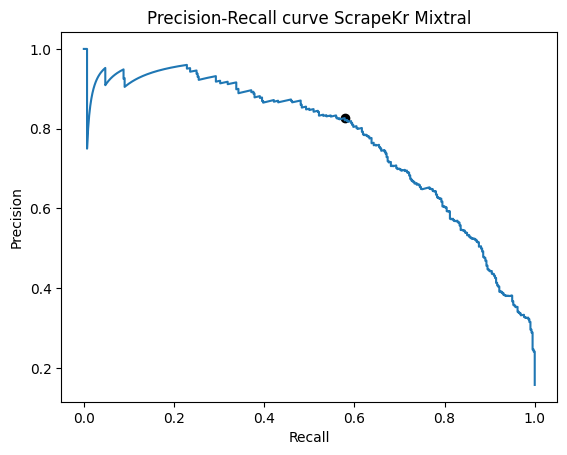

In [119]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve ScrapeKr Mixtral")
plt.plot(recall,precision)
plt.scatter(recall[index], precision[index], marker='o', color='black', label='Best')

# Compute 5-Eval-sets Metrics for E5 Best Model

total length: 8472
Threshold:  0.4431
Fbeta:  0.3925
auprc:  0.3129
Precision:  0.3916
Recall:  0.3963


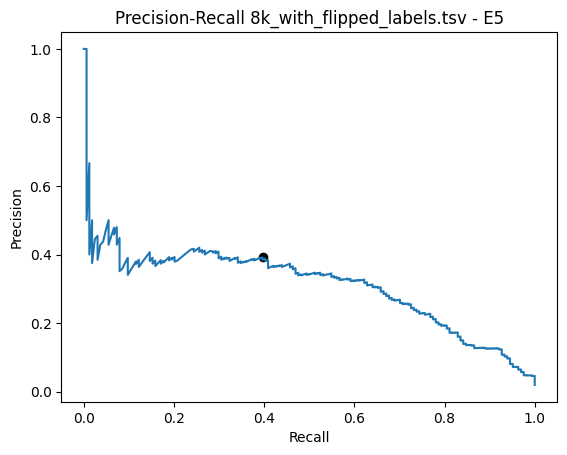

In [19]:
# Compute metrics for E5-Panashe-fulldata-model
Label = []
Pred = []
eval_sets = ['scrapekr1.2_spamllm2.4.parquet', 'spamgtx5.0_UHRSoutput.parquet', 'Clean_60k.tsv', '8k_with_flipped_labels.tsv', 'test_dataset_2024_03_05.tsv', 'auditor_ym_escape1.tsv']
# eval_sets = ["scrapekr1.2_spamllm2.4_UrlExpectedLabel_escape.tsv", "spamgtx5.0_UHRSoutput_escape.tsv", "Clean_60k_escape.tsv", "8k_with_flipped_labels_escape.tsv", "auditor_ym_escape1.tsv"]
# eval_sets = ['scrapekr1.2_spamllm2.4.parquet', 'spamgtx5.0_UHRSoutput_201.parquet', 'Clean_60k.tsv', 'test_dataset_2024_03_05.tsv']
cur_eval_set = eval_sets[3]
# count = 0
for i in range(0,3,1):
# for i in range(0,2,1):
    # with open(f'/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mistral_New_ym_e5_v3/model_2100/{cur_eval_set}_{i}.tsv', 'r') as f:
    # with open(f'/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mistral_New_ym_e5_v2/current_model_1500/{cur_eval_set}_{i}.tsv', 'r') as f:
    # with open(f'/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mistral_New_ym_e5_v1/current_best_1300/{cur_eval_set}_{i}.tsv', 'r') as f:
    with open(f'/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mistral_New_ym_e5_v1/current_best_1000/{cur_eval_set}_new_scapekr_{i}.tsv', 'r') as f:
    # with open(f'/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/qwen_no_overlap_o1_a3_v1/model_4200/{cur_eval_set}_{i}.tsv', 'r') as f:
        for line in f.readlines():
            # count += 1
            split_line = line.strip().split('\t')
            
            # if i == 1 and count == 276:
            #     continue
            Label.append(float(split_line[0]))
            # print('-->>> float(split_line[1]): ', split_line[1], 'current_i: ', i, ', count: ', count)
            Pred.append(float(split_line[1]))
print(f'total length: {len(Label)}')

from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(Label, Pred)
beta=0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",round(thresholds[index],4))
print("Fbeta: ",round(fbeta[index],4))
print("auprc: ", round(average_precision_score(Label, Pred),4))
print("Precision: ",round(precision[index],4))
print("Recall: ",round(recall[index],4)) 

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall {cur_eval_set} - E5")
plt.plot(recall,precision)
plt.scatter(recall[index], precision[index], marker='o', color='black', label='Best')

### Calculate metrics for balanced dataset

In [18]:
# df = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/FullTrain/Llama3_O1_A3_crowd_data_low_lr/test_2500_dataset_prediction_file.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_ym/test_2500_dataset_prediction_file.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/test_dataset_2024_03_05.tsv_2700.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test/model_1900/test_dataset_2024_03_05.tsv_1900.tsv",sep="\t")
# df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/current_best_2200/test_dataset_2024_03_05.tsv_2200.tsv",sep="\t")
df = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_label_v1/current_best_1200/test_dataset_2024_03_05_escape.tsv_new_scrapekr_expected_label_1200.tsv",sep="\t")

# df_balanced = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/EvaluationSets/test_dataset_2024_03_05.tsv",sep="\t")[["Url","UrlTitle","UrlSnippet","FullBody","Label"]]
df_balanced = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/test_dataset_2024_03_05.tsv",sep="\t")[["Url","UrlTitle","UrlSnippet","FullBody","Label"]]

df_balanced["Label"] = df_balanced["Label"].apply(lambda x:int(x.replace("<ANS>","").replace("</ANS>","")))

test_df = pd.merge(df,df_balanced,on=["Url","UrlTitle","UrlSnippet","FullBody"])
test_df["PositiveProb"] = test_df[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(test_df["Label"], test_df["PositiveProb"])
beta=0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print("auprc: ", average_precision_score(test_df["Label"], test_df["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])

Threshold:  0.07165699999999997
Fbeta:  0.9452846975002493
auprc:  0.9799955536204481
Precision:  0.9725400457665904
Recall:  0.85


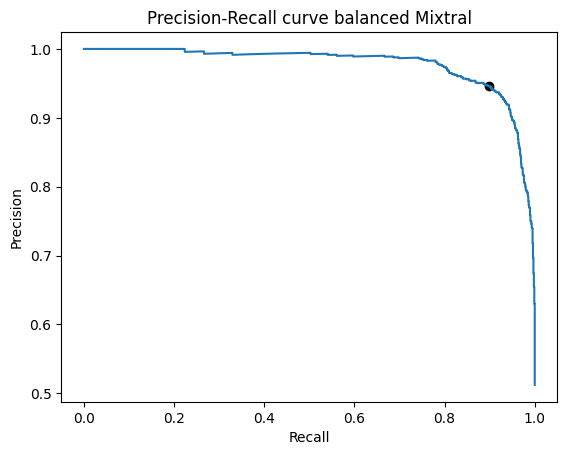

In [123]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve balanced Mixtral")
plt.plot(recall,precision)
plt.scatter(recall[index], precision[index], marker='o', color='black', label='Best')

# Calculate metrics for Auditor

In [41]:
df_pred = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/current_best_3600/auditor_ym_escape1.tsv_new_scrapekr_expected_label_3600.tsv",sep="\t")

df_aditor = pd.read_csv("/cosmos/local/users/zifanwang/SpamLLM/data/auditor_ym_escape1.tsv", sep='\t', header=None, names=['Url', 'UrlTitle', 'UrlSnippet', 'FullBody', 'Label'])

df_merged = pd.merge(df_pred,df_aditor,on=["Url","UrlTitle","UrlSnippet","FullBody"])
df_merged["PositiveProb"] = df_merged[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
print(len(df_pred), len(df_gtx), len(df_merged))
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_merged["Label"], df_merged["PositiveProb"])
beta=0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print("auprc: ", average_precision_score(df_merged["Label"], df_merged["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])

43853 419 43853
Threshold:  0.8174844
Fbeta:  0.5063721325287935
auprc:  0.4856562363457842
Precision:  0.6360725720384205
Recall:  0.2788956481048198


### Calculate metrics for gtx dataset

In [4]:

# df_pred = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/FullTrain/Llama3_O1_A3_crowd_data_low_lr/gtx_2500_dataset_prediction_file.tsv",sep="\t")
# df_pred = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/spamgtx5.0_UHRSoutput_201.parquet_2700.tsv",sep="\t")
# df_pred = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test/model_1900/spamgtx5.0_UHRSoutput_201.parquet_1900.tsv",sep="\t")
# df_pred = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/current_best_2200/spamgtx5.0_UHRSoutput.parquet_2200.tsv",sep="\t")
# df_pred = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/current_best_1900/spamgtx5.0_UHRSoutput.parquet_new_scrapekr_1900.tsv",sep="\t")
df_pred = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_label_v1/current_best_1200/spamgtx5.0_UHRSoutput_escape.tsv_new_scrapekr_expected_label_1200.tsv",sep="\t")

# below file is not exist
# df_gtx = pd.read_parquet("/data/local/IndexQuality/FinetuneLLM/EvaluationSets/spamgtx5.0_UHRSoutput 1.parquet")
# df_gtx = pd.read_parquet("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/spamgtx5.0_UHRSoutput_201.parquet")
df_gtx = pd.read_parquet("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/spamgtx5.0_UHRSoutput.parquet")

df_gtx["Label"] = df_gtx["AuditorJudgment"].apply(lambda x: 0 if x =='not spam' else 1)
df_gtx = df_gtx[["Url","UrlTitle","UrlSnippet","FullBody","Label"]]
df_merged = pd.merge(df_pred,df_gtx,on=["Url","UrlTitle","UrlSnippet","FullBody"])
df_merged["PositiveProb"] = df_merged[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
print(len(df_pred), len(df_gtx), len(df_merged))
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_merged["Label"], df_merged["PositiveProb"])
beta=0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print("auprc: ", average_precision_score(df_merged["Label"], df_merged["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])

419 419 419
Threshold:  0.24514829999999999
Fbeta:  0.7948717948612439
auprc:  0.849541082175153
Precision:  0.9117647058823529
Recall:  0.5254237288135594


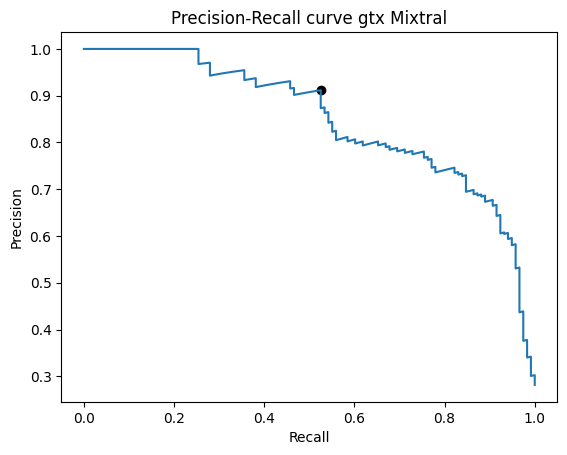

In [14]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve gtx Mixtral")
plt.plot(recall,precision)
plt.scatter(recall[index], precision[index], marker='o', color='black', label='Best')


### Calculating metrics for 60k metrics

In [43]:
# df_60k = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/EvaluationSets/Clean_60k.tsv",sep="\t",lineterminator="\n").drop_duplicates()
df_60k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/Clean_60k.tsv",sep="\t",lineterminator="\n").drop_duplicates()  # columns: ['Unnamed: 0', 'Url', 'UrlTitle', 'UrlSnippet', 'FullBody', 'Label']

# df_pred_60k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_ym/60k_2500_dataset_prediction_file.tsv",sep="\t",lineterminator="\n").drop_duplicates()
# df_pred_60k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/Clean_60k.tsv_2700.tsv",sep="\t",lineterminator="\n").drop_duplicates()
# df_pred_60k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test/model_1900/Clean_60k.tsv_1900.tsv",sep="\t",lineterminator="\n").drop_duplicates()
# df_pred_60k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/current_best_2200/Clean_60k.tsv_2200.tsv",sep="\t",lineterminator="\n").drop_duplicates()
df_pred_60k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/current_best_3600/Clean_60k_escape.tsv_new_scrapekr_expected_label_3600.tsv",sep="\t",lineterminator="\n").drop_duplicates()

df_merged = pd.merge(df_pred_60k,df_60k,on=["Url","UrlTitle","UrlSnippet","FullBody"])
df_merged = df_merged.drop("Unnamed: 0",axis=1)
df_merged["PositiveProb"] = df_merged[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
df_merged = df_merged.drop_duplicates()
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_merged["Label"], df_merged["PositiveProb"])

beta=0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print('auprc: ', average_precision_score(df_merged["Label"], df_merged["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])


Threshold:  0.46886026999999997
Fbeta:  0.7082082081982222
auprc:  0.680079022434977
Precision:  0.7823082239115411
Recall:  0.5136116152450091


In [81]:
df_60k.columns

Index(['Unnamed: 0', 'Url', 'UrlTitle', 'UrlSnippet', 'FullBody', 'Label'], dtype='object')

In [82]:
df_pred_60k.columns

Index(['Url', 'UrlTitle', 'UrlSnippet', 'FullBody', 'Prediction',
       'Probability'],
      dtype='object')

In [88]:
df_pred_60k.Prediction.value_counts()

Prediction
0    59506
1      598
Name: count, dtype: int64

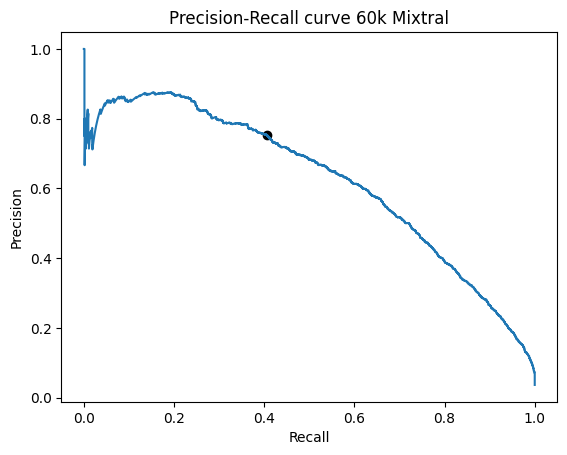

In [16]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve 60k Mixtral")
plt.plot(recall,precision)
plt.scatter(recall[index], precision[index], marker='o', color='black', label='Best')

### Calculating metrics 8k

In [44]:
# df_pred_8k = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/FullTrain/Llama3_O1_A3_crowd_data_low_lr/8k_2500_dataset_prediction_file_1.tsv",sep="\t")
# df_pred_8k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_ym/8k_2500_dataset_prediction_file_1.tsv",sep="\t")
# df_pred_8k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_7B_fulldata_finetuned_ym_bs_10/8k_with_flipped_labels.tsv_2700.tsv",sep="\t")  # count: 8472
# df_pred_8k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test/model_1900/8k_with_flipped_labels.tsv_1900.tsv",sep="\t")  # count: 8472
# df_pred_8k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/Mixtral_New_ym_bs_10_test_v4/current_best_2200/8k_with_flipped_labels.tsv_2200.tsv",sep="\t")  # count: 8472
df_pred_8k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/FullTrainTest/mixtral_crowd_master_label_v1/current_best_3600/8k_with_flipped_labels_escape.tsv_new_scrapekr_expected_label_3600.tsv",sep="\t")  # count: 8472

# df_pred_8k = df_pred_8k[['UrlID', 'Url', 'UrlTitle', 'UrlSnippet', 'FullBody']]

# df_8k = pd.read_csv("/data/local/IndexQuality/FinetuneLLM/EvaluationSets/8k_with_flipped_labels.tsv",sep="\t")
df_8k = pd.read_csv("/cosmos/local/IndexQuality/FinetuneLLM/EvaluationSets/8k_with_flipped_labels.tsv",sep="\t")

#df_8k = df_8k.drop("Unnamed: 0",axis=1)

# df_merged = pd.merge(df_pred_8k,df_8k[["UrlID","Label"]],on=["UrlID"])
# df_merged = pd.merge(df_pred_8k,df_8k[["UrlID","Label"]],on=["UrlID", "Label"])
df_merged = pd.merge(df_pred_8k,df_8k,on=["Url","UrlTitle","UrlSnippet","FullBody"])
df_merged["PositiveProb"] = df_merged[["Prediction","Probability"]].apply(lambda x:1-x["Probability"] if x["Prediction"]==0 else x["Probability"],axis=1)
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_merged["Label"], df_merged["PositiveProb"])
beta=0.5
fbeta = (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 0.00000000001)
index = np.nanargmax(fbeta)

print("Threshold: ",thresholds[index])
print("Fbeta: ",fbeta[index])
print("auprc: ", average_precision_score(df_merged["Label"], df_merged["PositiveProb"]))
print("Precision: ",precision[index])
print("Recall: ",recall[index])

Threshold:  0.7310157
Fbeta:  0.4012345678905655
auprc:  0.3509176690098609
Precision:  0.4642857142857143
Recall:  0.26


In [95]:
len(df_merged)

8726

In [93]:
df_8k.columns

Index(['UrlID', 'Url', 'UrlTitle', 'UrlSnippet', 'FullBody', 'Label'], dtype='object')

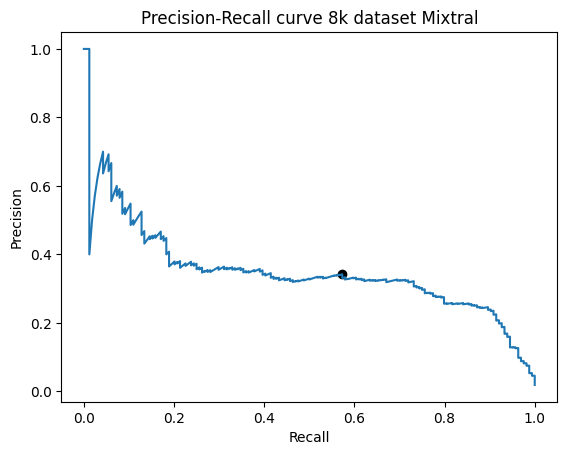

In [132]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve 8k dataset Mixtral")
plt.plot(recall,precision)
plt.scatter(recall[index], precision[index], marker='o', color='black', label='Best')

0.18849896610761724

Precision:  0.3855421686746988
Recall:  0.1951219512195122
